Types of plots:
Boxplot/violinplot
- per class for each model
- average, but models side by side
Wandb
- loss functions evolution
- loss/dice evolution of top models

In [50]:
import numpy as np
import matplotlib.pyplot as plt

(1, 1967, 5)
Total nr of valid images: 1967
Heart perfect score image count: 1536
Heart worst score image count: 223


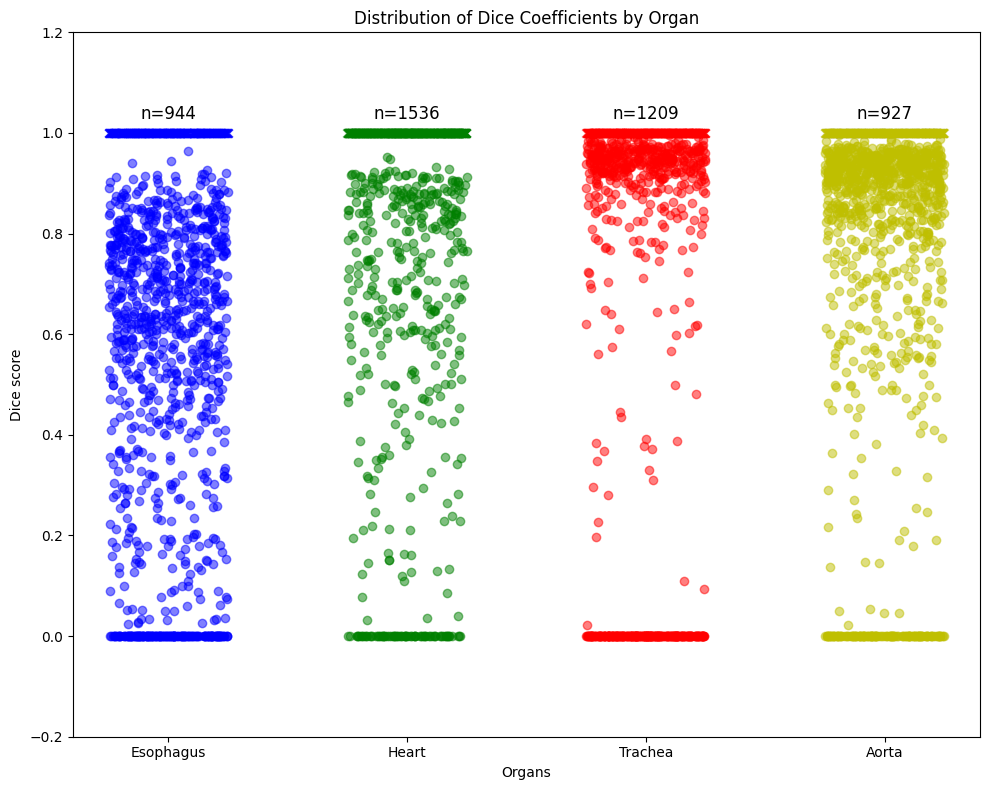

In [91]:
from pathlib import Path

base_path = Path('results/final_results/BASELINES/BASELINE1_ENet')
dice_metrics = np.load(base_path / 'dice_val.npy')
print(dice_metrics.shape)


def jitter_dots(dots):
    offsets = dots.get_offsets()
    jittered_offsets = offsets
    # only jitter in the x-direction
    jittered_offsets[:, 0] += np.random.uniform(-5, 5, offsets.shape[0])
    # jittered_offsets[:, 1] += np.random.uniform(-0.1, 0.1, offsets.shape[0])
    dots.set_offsets(jittered_offsets)

fig, ax1 = plt.subplots()

fig.set_size_inches(10, 8)
columns = ['Esophagus', 'Heart', 'Trachea', 'Aorta']
colors = ['b', 'g', 'r', 'y']
columns_pos = [10, 30, 50, 70]

all_valid_images = sorted(list(Path(base_path / 'iter000/val').glob('*.png')))
print(f"Total nr of valid images: {len(all_valid_images)}")
nr_esophagus_perfect_score = np.count_nonzero(dice_metrics[0, :, 2] == 1)
print(f"Heart perfect score image count: {nr_esophagus_perfect_score}")
print(f"Heart worst score image count: {np.count_nonzero(dice_metrics[0, :, 1] < 0.1)}")


# c = df_1['Delta_7']

for i, column in enumerate(columns):
    # dots = plt.scatter(np.full((len(metrics[0]), 1), columns_pos[i]), metrics[0, :, i], s=50, c=c, cmap='plasma')
    
    K = i + 1
    # lower_than_1 = dice_metrics[0, :, K][dice_metrics[0, :, K] < 1.1]
    # dots = plt.scatter(np.full((len(lower_than_1), 1), columns_pos[i]), lower_than_1, alpha=0.5)
    # jitter_dots(dots)
    
    all_scores = dice_metrics[0, :, K]
    perfect_scores = all_scores == 1
    worst_scores = all_scores < 0.1
    # Plot non-perfect scores
    dots = plt.scatter(np.full((len(all_scores[~perfect_scores]), 1), columns_pos[i]),
                       all_scores[~perfect_scores], color=colors[i], alpha=0.5)
    jitter_dots(dots)
    # Plot perfect scores with a different marker
    if np.any(perfect_scores):
        perfect_dots = plt.scatter(np.full((len(all_scores[perfect_scores]), 1), columns_pos[i]),
                    all_scores[perfect_scores], color=colors[i], marker='x', alpha=0.2)
        jitter_dots(perfect_dots)
    # Add text annotation with the number of perfect scores
    num_perfect_scores = np.sum(perfect_scores)
    plt.text(columns_pos[i], 1.02, f'n={num_perfect_scores}', ha='center', va='bottom', fontsize=12)
    plt.text(columns_pos[i], 1.02, f'n={num_perfect_scores}', ha='center', va='bottom', fontsize=12)



plt.xticks(columns_pos, columns)
plt.xlabel('Organs')
xmin, xmax = plt.xlim()
plt.xlim(xmin - 5, xmax + 5)  # make some room to show the jittered dots
plt.ylabel('Dice score')
plt.ylim(-0.2, 1.2)
plt.title('Distribution of Dice Coefficients by Organ')
plt.tight_layout()
plt.show()

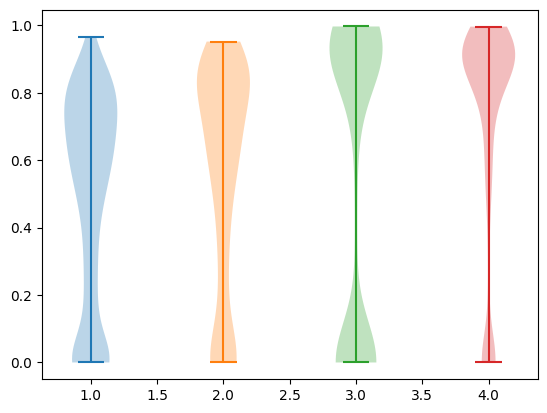

In [61]:
fig = plt.figure()
ax = fig.gca()
x = []
for i in range(1,5):
    data = dice_metrics[0, :, i]  # All samples for this class
    x.append(data)
    ax.violinplot(data[data<1], positions=[i], widths=0.4)
plt.show()